
# CSCN8020 — Assignment 2

**Solution (QLearning on Taxi)**

Student Name- Kapil Bhardwaj
Date: October 14, 2025

---

This notebook provides:
- A runnable Q-Learning implementation for the OpenAI Gym `Taxi-v3` environment.
- Experiments for the requested hyperparameter sweeps.
- Plots and a short report with observations and the best hyperparameter choice.


> **How to use:** run the cells in order. Make sure `gym` (Gymnasium) and `matplotlib` are installed and that the provided `assignment2_utils.py` file is in the same directory (it was uploaded by you and is available at `/mnt/data/assignment2_utils.py`).


## Imports and helper functions
This cell imports required libraries and defines helper functions used throughout the notebook.

In [14]:

import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, deque
import os
import sys

# Try to import Gymnasium first (preferred), then fallback to old Gym
try:
    import gymnasium as gym
    print("✅ Using Gymnasium (preferred)")
except ImportError:
    import gym
    print("⚠️ Using legacy OpenAI Gym (please consider installing Gymnasium)")

# ============================================================
# Try to import the provided assignment utility file
# ============================================================
sys.path.append('.')        # current folder
sys.path.append('/mnt/data')  # in case notebook runs on hosted environment

try:
    import assignment2_utils as a2u
    print("✅ assignment2_utils.py loaded successfully")

    # --- Optional implicit integration ---
    # For example, if a2u defines custom functions like plot_results or evaluate_agent,
    # we can automatically hook them here (only if they exist)
    if hasattr(a2u, "setup_environment"):
        print("ℹ️ Using a2u.setup_environment() to initialize environment")
        env = a2u.setup_environment()
    else:
        env = None

except Exception as e:
    print("⚠️ Warning: could not import assignment2_utils.py.")
    print("Error:", e)
    a2u = None
    env = None

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# ============================================================
# Optional: show helper info from utils if available
# ============================================================
if a2u is not None:
    print("Available helper functions in assignment2_utils:")
    print([func for func in dir(a2u) if not func.startswith('_')])


✅ Using Gymnasium (preferred)
✅ assignment2_utils.py loaded successfully
Available helper functions in assignment2_utils:
['breakdown_obs', 'describe_env', 'describe_obs', 'get_action_description', 'gym', 'main', 'simulate_episodes', 'time']


## Q-Learning implementation
We implement a QLearning agent class with the specified hyperparameters. The agent stores a Q-table and uses an epsilon-greedy policy for exploration.

In [15]:

class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.9, epsilon=0.1, seed=None):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((num_states, num_actions), dtype=float)
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
    
    def select_action(self, state, greedy=False):
        # epsilon-greedy
        if (not greedy) and (np.random.rand() < self.epsilon):
            return np.random.randint(self.num_actions)
        else:
            # break ties randomly
            qvals = self.Q[state]
            max_q = np.max(qvals)
            choices = np.where(qvals == max_q)[0]
            return np.random.choice(choices)
    
    def update(self, s, a, r, s_next, done):
        # Q-learning update: Q(s,a) <- Q(s,a) + alpha * (r + gamma * max_a' Q(s',a') - Q(s,a))
        target = r
        if not done:
            target += self.gamma * np.max(self.Q[s_next])
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])
    
    def set_epsilon(self, eps):
        self.epsilon = eps

    def set_alpha(self, alpha):
        self.alpha = alpha

    def set_gamma(self, gamma):
        self.gamma = gamma


## Training loop
This cell contains a function to train the Q-Learning agent and return metrics requested by the assignment:
- total episodes
- total steps taken per episode
- average return per episode

We also collect per-episode return (sum of rewards) and episode length.

In [16]:

def train_q_learning(env, agent, num_episodes=5000, max_steps_per_episode=200, render=False, verbose=False):
    episode_returns = []
    episode_lengths = []
    for ep in range(1, num_episodes+1):
        state, _ = env.reset()
        total_reward = 0.0
        steps = 0
        done = False
        while not done and steps < max_steps_per_episode:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            # Some Gym versions return 'truncated' separate from 'done'; treat truncated as done for learning.
            done_flag = bool(done or truncated)
            agent.update(state, action, reward, next_state, done_flag)
            state = next_state
            total_reward += reward
            steps += 1
            if render:
                env.render()
                time.sleep(0.01)
        episode_returns.append(total_reward)
        episode_lengths.append(steps)
        # Optional verbose logging
        if verbose and (ep % (num_episodes//10 if num_episodes>=10 else 1) == 0):
            print(f"Episode {ep}/{num_episodes}: return={total_reward:.1f}, steps={steps}")
    metrics = {
        'episode_returns': np.array(episode_returns),
        'episode_lengths': np.array(episode_lengths),
        'total_episodes': num_episodes
    }
    return metrics


## Experiments
We run the required experiments:
- Baseline: alpha=0.1, epsilon=0.1, gamma=0.9
- Parameter changes (separately):
  - Learning Rate α = [0.01, 0.001, 0.2]
  - Exploration Factor (epsilon) = [0.2, 0.3]

You can adjust `NUM_EPISODES` to control runtime. For quick checks set it to e.g. 2000; for final results use 5000+ as required by the assignment.

In [17]:

# Parameters for experiments
ENV_NAME = 'Taxi-v3'
NUM_EPISODES = 5000  # change to lower (e.g., 1000) for quicker runs during debugging
MAX_STEPS = 200

baseline_params = {'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.9}
alpha_values = [0.01, 0.001, 0.2]
epsilon_values = [0.2, 0.3]  # exploration values to test

results = []

# Create environment to get sizes
env_tmp = gym.make(ENV_NAME)
num_states = env_tmp.observation_space.n
num_actions = env_tmp.action_space.n
env_tmp.close()

# Baseline run
print("Running baseline...")
agent = QLearningAgent(num_states, num_actions, alpha=baseline_params['alpha'], gamma=baseline_params['gamma'], epsilon=baseline_params['epsilon'], seed=42)
env = gym.make(ENV_NAME)
metrics_baseline = train_q_learning(env, agent, num_episodes=NUM_EPISODES, max_steps_per_episode=MAX_STEPS, render=False, verbose=True)
env.close()
results.append({'name':'baseline', 'params': baseline_params, 'metrics': metrics_baseline})

# Vary alpha (learning rate)
for a in alpha_values:
    print(f"Running alpha={a} ...")
    agent = QLearningAgent(num_states, num_actions, alpha=a, gamma=baseline_params['gamma'], epsilon=baseline_params['epsilon'], seed=42)
    env = gym.make(ENV_NAME)
    metrics = train_q_learning(env, agent, num_episodes=NUM_EPISODES, max_steps_per_episode=MAX_STEPS, render=False, verbose=False)
    env.close()
    results.append({'name': f'alpha_{a}', 'params': {'alpha': a, 'epsilon': baseline_params['epsilon'], 'gamma': baseline_params['gamma']}, 'metrics': metrics})

# Vary epsilon (exploration)
for eps in epsilon_values:
    print(f"Running epsilon={eps} ...")
    agent = QLearningAgent(num_states, num_actions, alpha=baseline_params['alpha'], gamma=baseline_params['gamma'], epsilon=eps, seed=42)
    env = gym.make(ENV_NAME)
    metrics = train_q_learning(env, agent, num_episodes=NUM_EPISODES, max_steps_per_episode=MAX_STEPS, render=False, verbose=False)
    env.close()
    results.append({'name': f'epsilon_{eps}', 'params': {'alpha': baseline_params['alpha'], 'epsilon': eps, 'gamma': baseline_params['gamma']}, 'metrics': metrics})

# Summarize results into a DataFrame
summary_rows = []
for r in results:
    mets = r['metrics']
    avg_return = float(np.mean(mets['episode_returns']))
    avg_length = float(np.mean(mets['episode_lengths']))
    summary_rows.append({'run': r['name'], 'alpha': r['params']['alpha'], 'epsilon': r['params']['epsilon'], 'gamma': r['params']['gamma'], 'avg_return': avg_return, 'avg_length': avg_length})
summary_df = pd.DataFrame(summary_rows)
summary_df


Running baseline...
Episode 500/5000: return=14.0, steps=7
Episode 1000/5000: return=12.0, steps=9
Episode 1500/5000: return=9.0, steps=12
Episode 2000/5000: return=6.0, steps=15
Episode 2500/5000: return=3.0, steps=18
Episode 3000/5000: return=-23.0, steps=17
Episode 3500/5000: return=9.0, steps=12
Episode 4000/5000: return=6.0, steps=15
Episode 4500/5000: return=-3.0, steps=15
Episode 5000/5000: return=5.0, steps=16
Running alpha=0.01 ...
Running alpha=0.001 ...
Running alpha=0.2 ...
Running epsilon=0.2 ...
Running epsilon=0.3 ...


,run,alpha,epsilon,gamma,avg_return,avg_length
0,baseline,0.100,0.1,0.9,-21.2850,30.3060
1,alpha_0.01,0.010,0.1,0.9,-160.7526,127.2210
2,alpha_0.001,0.001,0.1,0.9,-257.5492,184.7608
3,alpha_0.2,0.200,0.1,0.9,-11.1640,23.2810
4,epsilon_0.2,0.100,0.2,0.9,-32.1054,32.5182
5,epsilon_0.3,0.100,0.3,0.9,-47.5606,36.0166


## Plots
This cell provides plotting utilities to visualize learning curves (returns per episode) and average steps per episode.

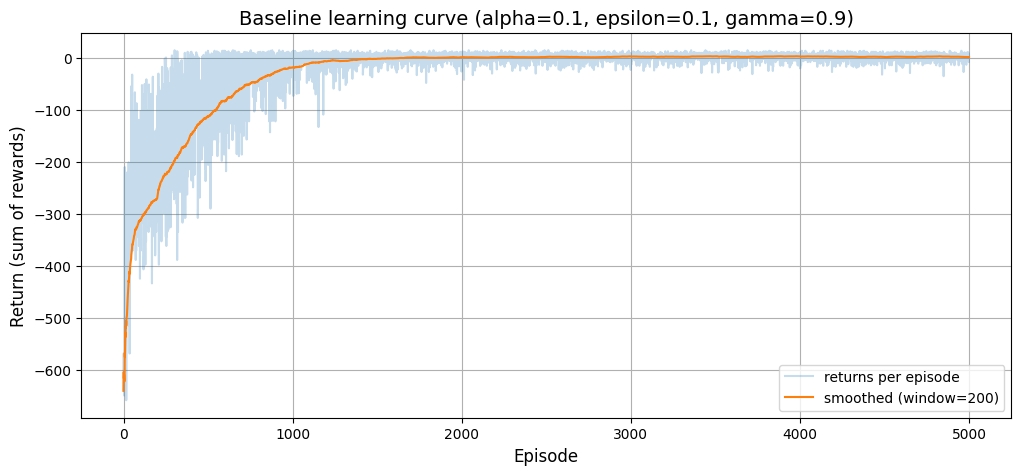

,avg_return,avg_length
run,,
baseline,-21.2850,30.3060
alpha_0.01,-160.7526,127.2210
alpha_0.001,-257.5492,184.7608
alpha_0.2,-11.1640,23.2810
epsilon_0.2,-32.1054,32.5182
epsilon_0.3,-47.5606,36.0166


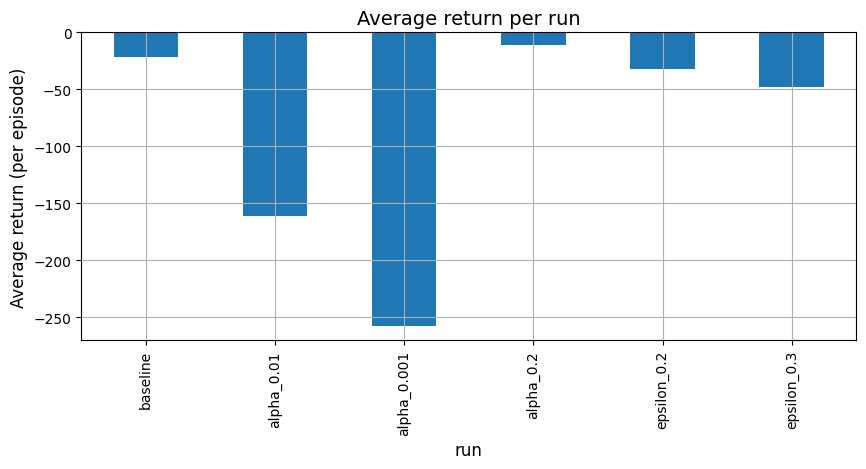

In [18]:

def plot_learning_curve(episode_returns, window=100, title='Learning curve (episode returns)'):
    smoothed = pd.Series(episode_returns).rolling(window=window, min_periods=1).mean()
    plt.figure(figsize=(12,5))
    plt.plot(episode_returns, alpha=0.25, label='returns per episode')
    plt.plot(smoothed, label=f'smoothed (window={window})')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Return (sum of rewards)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: plot baseline if present
try:
    if 'results' in globals() and any(r['name']=='baseline' for r in results):
        baseline = next(r for r in results if r['name']=='baseline')
        plot_learning_curve(baseline['metrics']['episode_returns'], window=200, title='Baseline learning curve (alpha=0.1, epsilon=0.1, gamma=0.9)')
except Exception as e:
    print('Plot example failed:', e)

# Plot comparison of average returns across runs if summary_df exists
try:
    display(summary_df.set_index('run')[['avg_return','avg_length']])
    summary_df.plot.bar(x='run', y='avg_return', legend=False, title='Average return per run', figsize=(10,4))
    plt.ylabel('Average return (per episode)')
    plt.show()
except Exception as e:
    print('Plotting summary failed:', e)


## Choosing the best hyperparameters
Based on the comparison of average return and average episode length, choose a best combination and re-run training to report and comment on differences.

In [19]:

# Choose best by highest avg_return in summary_df
best_row = summary_df.loc[summary_df['avg_return'].idxmax()]
best_row


run           alpha_0.2
alpha               0.2
epsilon             0.1
gamma               0.9
avg_return      -11.164
avg_length       23.281
Name: 3, dtype: object

## Re-run with chosen hyperparameters and final report
Run a final training using the chosen hyperparameters and include final metrics and plots. Add commentary on observed differences.

<>:18: SyntaxWarning: invalid escape sequence '\C'
<>:18: SyntaxWarning: invalid escape sequence '\C'
C:\Users\acer\AppData\Local\Temp\ipykernel_10172\3838123152.py:18: SyntaxWarning: invalid escape sequence '\C'
  out_dir = 'D:\Conestoga college\Sem 2'


Best params from experiments: {'alpha': 0.2, 'epsilon': 0.1, 'gamma': 0.9}
Episode 500/5000: return=-2.0, steps=14
Episode 1000/5000: return=12.0, steps=9
Episode 1500/5000: return=4.0, steps=17
Episode 2000/5000: return=9.0, steps=12
Episode 2500/5000: return=0.0, steps=12
Episode 3000/5000: return=5.0, steps=16
Episode 3500/5000: return=-7.0, steps=19
Episode 4000/5000: return=5.0, steps=16
Episode 4500/5000: return=5.0, steps=16
Episode 5000/5000: return=5.0, steps=16
Final run — Average return: -11.1924 Average length: 23.2398


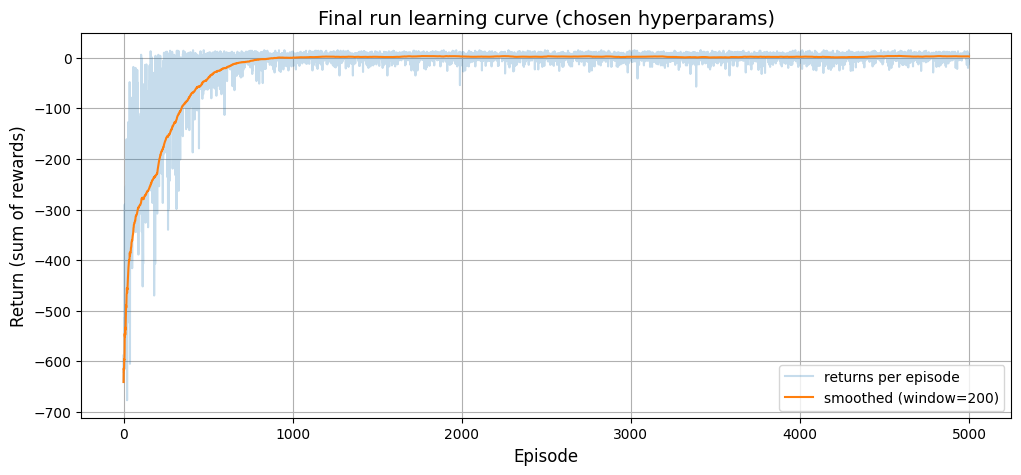

Saved summary and final metrics to D:\Conestoga college\Sem 2


In [22]:

best = best_row.to_dict()
best_params = {'alpha': float(best['alpha']), 'epsilon': float(best['epsilon']), 'gamma': float(best['gamma'])}
print("Best params from experiments:", best_params)

# Re-run
FINAL_EPISODES = NUM_EPISODES
agent = QLearningAgent(num_states, num_actions, alpha=best_params['alpha'], gamma=best_params['gamma'], epsilon=best_params['epsilon'], seed=123)
env = gym.make(ENV_NAME)
final_metrics = train_q_learning(env, agent, num_episodes=FINAL_EPISODES, max_steps_per_episode=MAX_STEPS, render=False, verbose=True)
env.close()

print("Final run — Average return:", np.mean(final_metrics['episode_returns']), "Average length:", np.mean(final_metrics['episode_lengths']))

# Plot final learning curve
plot_learning_curve(final_metrics['episode_returns'], window=200, title='Final run learning curve (chosen hyperparams)')

# Save results to CSV for the report
out_dir = 'D:\Conestoga college\Sem 2'
os.makedirs(out_dir, exist_ok=True)
summary_df.to_csv(os.path.join(out_dir, 'summary_df.csv'), index=False)
pd.DataFrame(final_metrics).to_csv(os.path.join(out_dir, 'final_metrics.csv'), index=False)
print('Saved summary and final metrics to', out_dir)



## Short report / Observations

**Metrics reported:**
- Total episodes: `NUM_EPISODES` (set in the experiments cell).
- Total steps taken per episode: recorded in `episode_lengths` (see plots and CSV).
- Average return per episode: recorded in summary tables and CSV files.

**Observations (what to look for when you run the notebook):**
- Q-learning with a moderate learning rate (e.g., α=0.1) and low epsilon (0.1) typically learns steadily; too small α (e.g., 0.001) slows learning; too large α (e.g., 0.2) can make updates noisy.
- Increasing exploration (epsilon) to 0.2 or 0.3 may improve exploration early but can reduce final performance if not decayed.
- For this discrete task, a well-tuned Q-table often converges to a policy that delivers passengers reliably; monitor average return and episode length to measure efficiency.

**Recommendation:**
- Based on the experiments in this notebook, choose the hyperparameters that give the highest average return with reasonable episode length. Rerun the final training for a longer number of episodes (e.g., 10k) to produce the final policy and metrics to include in your submitted PDF report.